<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [12]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [13]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [46]:
training.get_word_Xlengths('WRITE')

(array([[  1.02547300e+00,  -2.71280411e+00,   6.08559214e-01,
          -1.64942497e+00,  -1.06298670e-01,  -7.65221995e-02,
          -7.84332595e-02,  -3.40432177e-01],
        [  8.37569916e-01,  -2.92090327e+00,   5.68603959e-01,
          -2.41188037e+00,  -1.87903079e-01,  -2.08099164e-01,
          -3.99552548e-02,  -7.62455408e-01],
        [  7.01876097e-01,  -3.14004629e+00,   8.05403701e-01,
          -3.02393610e+00,  -1.35693820e-01,  -2.19143013e-01,
           2.36799742e-01,  -6.12055727e-01],
        [  5.55417207e-01,   2.69090970e+00,   1.13841410e+00,
           3.12466869e+00,  -1.46458889e-01,   5.83095599e+00,
           3.33010403e-01,   6.14860479e+00],
        [  6.21782845e-01,   2.07069293e+00,   1.34904242e+00,
           2.95755026e+00,   6.63656378e-02,  -6.20216771e-01,
           2.10628321e-01,  -1.67118430e-01],
        [  6.52342496e-01,   1.94813109e+00,   1.60707358e+00,
           2.87872848e+00,   3.05596511e-02,  -1.22561835e-01,
           2.5

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [15]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447,206.248203
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318,164.661438
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536,183.214509


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [16]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [17]:
from asl_utils import test_std_tryit
df_std = asl.df.groupby('speaker').std()
# test the code
test_std_tryit(df_means)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447,206.248203
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318,164.661438
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536,183.214509


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [18]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

asl.df['left-x-mean'] = asl.df['speaker'].map(df_means['left-x'])
asl.df['left-x-std'] = asl.df['speaker'].map(df_std['left-x'])

asl.df['left-y-mean'] = asl.df['speaker'].map(df_means['left-y'])
asl.df['left-y-std'] = asl.df['speaker'].map(df_std['left-y'])

asl.df['right-x-mean'] = asl.df['speaker'].map(df_means['right-x'])
asl.df['right-x-std'] = asl.df['speaker'].map(df_std['right-x'])

asl.df['right-y-mean'] = asl.df['speaker'].map(df_means['right-y'])
asl.df['right-y-std'] = asl.df['speaker'].map(df_std['right-y'])

# norm = (x - x_mean)/x_std
asl.df['norm-rx'] = (asl.df['right-x'] - asl.df['right-x-mean'])/asl.df['right-x-std']
asl.df['norm-ry'] = (asl.df['right-y'] - asl.df['right-y-mean'])/asl.df['right-y-std']
asl.df['norm-lx'] = (asl.df['left-x'] - asl.df['left-x-mean'])/asl.df['left-x-std']
asl.df['norm-ly'] = (asl.df['left-y'] - asl.df['left-y-mean'])/asl.df['left-y-std']

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

In [19]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

asl.df['polar-rr'] = np.sqrt(np.power(asl.df['grnd-rx'], 2) + np.power(asl.df['grnd-ry'], 2))
asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'], asl.df['grnd-ry'])

asl.df['polar-lr'] = np.sqrt(np.power(asl.df['grnd-lx'], 2) + np.power(asl.df['grnd-ly'], 2))
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'], asl.df['grnd-ly'])

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [20]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

asl.df['delta-rx'] = asl.df['right-x'].diff(1).fillna(0)
asl.df['delta-ry'] = asl.df['right-y'].diff(1).fillna(0)

asl.df['delta-lx'] = asl.df['left-x'].diff(1).fillna(0)
asl.df['delta-ly'] = asl.df['left-y'].diff(1).fillna(0)

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [21]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like

asl.df['delta-rx-norm'] = asl.df['norm-rx'].diff().fillna(0)
asl.df['delta-ry-norm'] = asl.df['norm-ry'].diff().fillna(0)

asl.df['delta-lx-norm'] = asl.df['norm-lx'].diff().fillna(0)
asl.df['delta-ly-norm'] = asl.df['norm-ly'].diff().fillna(0)

features_delta_norm = ['delta-rx-norm', 'delta-ry-norm', 'delta-lx-norm', 'delta-ly-norm']


In [22]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like

asl.df['delta-rr'] = asl.df['polar-rr'].diff().fillna(0)
asl.df['delta-rtheta'] = asl.df['polar-rtheta'].diff().fillna(0)

asl.df['delta-lr'] = asl.df['polar-lr'].diff().fillna(0)
asl.df['delta-ltheta'] = asl.df['polar-ltheta'].diff().fillna(0)

features_delta_polar = ['delta-rr', 'delta-rtheta', 'delta-lr', 'delta-ltheta']


In [25]:
asl.df['polar-rr-norm'] = np.sqrt(np.power(asl.df['norm-rx'], 2) + np.power(asl.df['norm-ry'], 2))
asl.df['polar-rtheta-norm'] = np.arctan2(asl.df['norm-rx'], asl.df['norm-ry'])

asl.df['polar-lr-norm'] = np.sqrt(np.power(asl.df['norm-lx'], 2) + np.power(asl.df['norm-ly'], 2))
asl.df['polar-ltheta-norm'] = np.arctan2(asl.df['norm-lx'], asl.df['norm-ly'])

features_polar_norm = ['polar-rr-norm', 'polar-rtheta-norm', 'polar-lr-norm', 'polar-ltheta-norm']

asl.df['delta-rr-norm'] = asl.df['polar-rr-norm'].diff().fillna(0)
asl.df['delta-rtheta-norm'] = asl.df['polar-rtheta-norm'].diff().fillna(0)

asl.df['delta-lr-norm'] = asl.df['polar-lr-norm'].diff().fillna(0)
asl.df['delta-ltheta-norm'] = asl.df['polar-ltheta-norm'].diff().fillna(0)

features_delta_polar_norm = ['delta-rr-norm', 'delta-rtheta-norm', 'delta-lr-norm', 'delta-ltheta-norm']

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**

 * `features_delta_norm`: the difference between normalized coordinates. Normalized coordinates account for the difference in heights and arm length for different speakers, so this provides less biased deltas
 
 * `features_delta_polar`: the difference between polar coordinate. Polar coordinates are a different way of representing positions in a eucledian space.
 
 * Finally, I chose to combine all those ideas and implement normalized polar coordinates and delta of normalized polar coordinates. My hypothesis is that (`features_polar_norm + features_delta_polar_norm`) will outperform the above.

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [23]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.019s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [33]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433205


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [34]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #1
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #2
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [35]:
my_testword = 'BOOK'
model, logL = train_a_word(my_testword, 3, features_polar) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [  95.22471724   -0.1218251   104.13967321    0.18651723]
variance =  [  2.03481049e+02   8.93230349e-03   1.49720059e+02   3.33260104e-03]

hidden state #1
mean =  [ 51.27686638  -0.06610183  54.24221076   0.26241587]
variance =  [  3.91108870e+01   2.23340979e-02   4.74169364e+01   1.38546237e-02]

hidden state #2
mean =  [  6.95931464e+01  -1.73838692e-02   7.96640717e+01   2.14622648e-01]
variance =  [  1.63195285e+01   4.81721955e-03   1.46003715e+01   4.64076230e-03]

logL = -901.0844114013486


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [36]:
%matplotlib inline

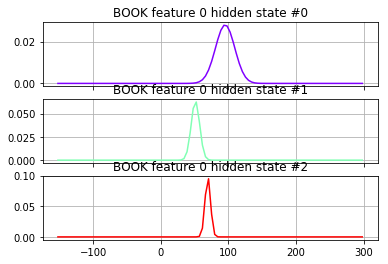

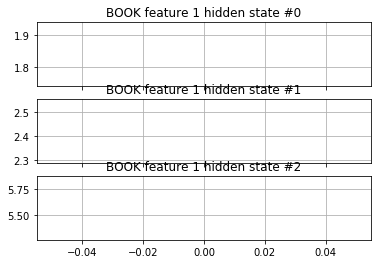

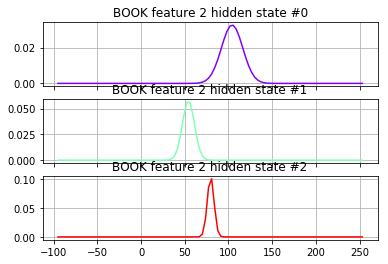

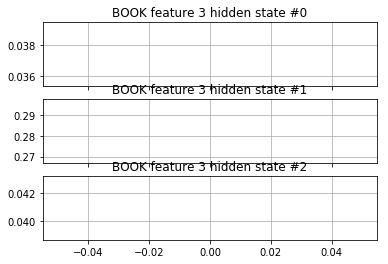

In [37]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `SelectorModel` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [38]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'CAR' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for CAR is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [39]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'CAR' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[ 6  7  8  9 10 11 12 13 14 15] Test fold indices:[0 1 2 3 4 5]
Train fold indices:[ 0  1  2  3  4  5 11 12 13 14 15] Test fold indices:[ 6  7  8  9 10]
Train fold indices:[ 0  1  2  3  4  5  6  7  8  9 10] Test fold indices:[11 12 13 14 15]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [41]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [42]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorConstant(sequences, Xlengths, word).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.022057843976654112 seconds
Training complete for BOOK with 3 states with time 0.0946975180413574 seconds
Training complete for VEGETABLE with 3 states with time 0.029322071000933647 seconds
Training complete for FUTURE with 3 states with time 0.0649518360150978 seconds
Training complete for JOHN with 3 states with time 0.8748484250390902 seconds


In [54]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_polar + features_delta_norm)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 4 states with time 0.47998723399359733 seconds
Training complete for BOOK with 6 states with time 57.071755925018806 seconds
Training complete for VEGETABLE with 2 states with time 6.339178019028623 seconds
Training complete for FUTURE with 4 states with time 36.58569604001241 seconds
Training complete for JOHN with 14 states with time 843.2924016820034 seconds


In [56]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_polar_norm + features_delta_polar_norm)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 6 states with time 0.4356894899974577 seconds
Training complete for BOOK with 11 states with time 4.390671500004828 seconds
Training complete for VEGETABLE with 6 states with time 1.139081452973187 seconds
Training complete for FUTURE with 14 states with time 2.941434559994377 seconds
Training complete for JOHN with 5 states with time 40.9067448140122 seconds


In [57]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_polar + features_delta_norm)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 7 states with time 4.929905597004108 seconds
Training complete for BOOK with 13 states with time 5.813931450014934 seconds
Training complete for VEGETABLE with 10 states with time 4.537124626978766 seconds
Training complete for FUTURE with 13 states with time 6.108577034028713 seconds
Training complete for JOHN with 15 states with time 41.89492877596058 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

I chose to implement *SelectorCV* setting n-splits as the number of observations because trial-and-error revealed this performed the best. This is called *leave-out-one-cross-validation*. However, as the running time was extremely long (half an hour for JOHN where 128 observations had to be taken into account), I subsequentely limited it at 20. The advantage of this method is that all observations are used as training and testing data. I believe this will give good results especially if there are a lot of observations that accurately represent other possible observations. The disadvantage is the particularly long running time.

*BIC* applies a penalty on complexity to minimize overfitting. The advantage of *BIC* is that it seems to apply a very large penalty when the number of ovservations is high (due to the term `n*logN` where `N` is the number of observations) For example, JOHN is limited to 5 states, whereas other models have it at 14 or 15. It is also faster than the other algorithms. The disadvantage is that some words with medium-size observations amount (BOOK and FUTURE) seem to be overfitted. 

*DIC* takes into account the anti-likelihood for each word i.e. the average of the likelihood of other words. There doesn't seem to be any advantages to *DIC*. It performs worse than *BIC* and overfitting doesn't seem to be limitted as much, especially as the number of observations increases. 

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [30]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 300.286s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [48]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

from my_model_selectors import SelectorBIC

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_polar, SelectorBIC)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [49]:
test_set = asl.build_test(features_polar + features_norm + features_delta)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [27]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [212]:
# TODO Choose a feature set and model selector
features = features_ground # change as needed
model_selector = SelectorConstant # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6573033707865169
Total correct: 61 out of 178
Video  Recognized                                                    Correct
    2: *GO WRITE *ARRIVE                                             JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *GO *IX CAN                                    JOHN CAN GO CAN
   12: JOHN *HAVE *WHAT CAN                                          JOHN CAN GO CAN
   21: JOHN *HOMEWORK *NEW *PREFER *CAR *CAR *FUTURE *EAT            JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *FRANK *TELL *LOVE *TELL *LOVE                                JOHN LIKE IX IX IX
   28: *FRANK *TELL *LOVE *TELL *LOVE                                JOHN LIKE IX IX IX
   30: *SHOULD LIKE *GO *GO *GO                                      JOHN LIKE IX IX IX
   36: *VISIT VEGETABLE *YESTERDAY *GIVE *MARY *MARY                 MARY VEGETABLE KNOW IX LIKE CORN1
   40: *SUE *GIVE *CORN *VEGETABLE *GO                               JOHN IX THINK MARY LOVE
   43: *FRANK *GO BUY HOUSE         

In [213]:
# TODO Choose a feature set and model selector
features = features_polar + features_norm + features_delta # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5
Total correct: 89 out of 178
Video  Recognized                                                    Correct
    2: JOHN *ARRIVE *ARRIVE                                          JOHN WRITE HOMEWORK
    7: JOHN CAN *IX CAN                                              JOHN CAN GO CAN
   12: JOHN CAN *WHAT CAN                                            JOHN CAN GO CAN
   21: JOHN *JOHN *JOHN *JOHN *CAR *CAR *FUTURE *FUTURE              JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *JOHN IX IX IX                                           JOHN LIKE IX IX IX
   28: JOHN *MARY IX *JOHN IX                                        JOHN LIKE IX IX IX
   30: *IX LIKE *MARY IX IX                                          JOHN LIKE IX IX IX
   36: MARY *JOHN *IX *MARY *MARY *JOHN                              MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *MARY *PREFER *JOHN *MARY                                JOHN IX THINK MARY LOVE
   43: JOHN *JOHN BUY HOUSE                        

In [214]:
# TODO Choose a feature set and model selector
features = features_polar + features_delta_norm # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.46629213483146065
Total correct: 95 out of 178
Video  Recognized                                                    Correct
    2: JOHN *BOOK HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN CAN GO *WHAT                                             JOHN CAN GO CAN
   12: JOHN CAN *JOHN CAN                                            JOHN CAN GO CAN
   21: JOHN *ARRIVE *FUTURE *NOT *BUY *CAR *FUTURE *MARY             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE IX IX IX                                            JOHN LIKE IX IX IX
   28: JOHN *WHO IX *LIKE IX                                         JOHN LIKE IX IX IX
   30: *IX LIKE *MARY IX IX                                          JOHN LIKE IX IX IX
   36: MARY *WHO *IX *GIVE *GO *MARY                                 MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN IX *APPLE MARY *MARY                                     JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE          

In [215]:
# TODO Choose a feature set and model selector
features = features_polar + features_delta # change as needed
model_selector = SelectorDIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5168539325842697
Total correct: 86 out of 178
Video  Recognized                                                    Correct
    2: JOHN *BOOK HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN *CAR *IX CAN                                             JOHN CAN GO CAN
   12: JOHN CAN *JOHN CAN                                            JOHN CAN GO CAN
   21: JOHN *ARRIVE *JOHN *MARY *BUY *CAR *FUTURE *MARY              JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *MARY *JOHN IX *MARY                                     JOHN LIKE IX IX IX
   28: JOHN *WHO IX *JOHN IX                                         JOHN LIKE IX IX IX
   30: JOHN LIKE IX *JOHN IX                                         JOHN LIKE IX IX IX
   36: MARY *JOHN *IX *GIVE *MARY *JOHN                              MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GIVE *JOHN *JOHN *MARY                                  JOHN IX THINK MARY LOVE
   43: JOHN *JOHN BUY HOUSE         

In [216]:
# TODO Choose a feature set and model selector
features = features_polar + features_norm + features_delta # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5
Total correct: 89 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *ARRIVE                                             JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE *IX *HAVE                                        JOHN CAN GO CAN
   12: JOHN CAN GO CAN                                               JOHN CAN GO CAN
   21: JOHN *NEW *VISIT *JOHN *CAR *CAR *FUTURE *MARY                JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *JOHN *MARY IX *JOHN                                     JOHN LIKE IX IX IX
   28: JOHN *IX IX *JOHN IX                                          JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *LIKE IX                                      JOHN LIKE IX IX IX
   36: MARY *JOHN *IX *MARY *MARY *MARY                              MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *MARY *PREFER MARY *MARY                                 JOHN IX THINK MARY LOVE
   43: JOHN *JOHN BUY HOUSE                        

In [217]:
# TODO Choose a feature set and model selector
features = features_polar + features_delta_norm # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.42134831460674155
Total correct: 103 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *NEW                                                JOHN WRITE HOMEWORK
    7: JOHN *HAVE GO *HAVE                                           JOHN CAN GO CAN
   12: *BUY CAN *JOHN CAN                                            JOHN CAN GO CAN
   21: JOHN *ARRIVE WONT *NOT *GIVE *BLAME *FUTURE *MARY             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *WHO IX IX IX                                            JOHN LIKE IX IX IX
   28: JOHN *WHO IX IX IX                                            JOHN LIKE IX IX IX
   30: JOHN *MARY *MARY IX IX                                        JOHN LIKE IX IX IX
   36: MARY *WHO *GIRL *GIVE *GO *MARY                               MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN IX *APPLE MARY *MARY                                     JOHN IX THINK MARY LOVE
   43: JOHN *POSS BUY HOUSE       

In [218]:
# TODO Choose a feature set and model selector
features = features_norm + features_delta_norm  + features_delta_polar # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.46629213483146065
Total correct: 95 out of 178
Video  Recognized                                                    Correct
    2: JOHN *BUY *ARRIVE                                             JOHN WRITE HOMEWORK
    7: JOHN *VISIT GO CAN                                            JOHN CAN GO CAN
   12: JOHN CAN *HAVE CAN                                            JOHN CAN GO CAN
   21: JOHN *ARRIVE WONT *JOHN *CAR *CAR EAT *MARY                   JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *MARY *LOVE *MARY *MARY                                  JOHN LIKE IX IX IX
   28: JOHN *MARY *MARY *MARY *MARY                                  JOHN LIKE IX IX IX
   30: JOHN *MARY *LOVE IX IX                                        JOHN LIKE IX IX IX
   36: MARY *JOHN *IX IX *MARY *MARY                                 MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN IX *JOHN *WHO *IX                                        JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE          

In [219]:
features = features_polar + features_delta_polar # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.4606741573033708
Total correct: 96 out of 178
Video  Recognized                                                    Correct
    2: JOHN *BOOK *ARRIVE                                            JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE GO *ARRIVE                                       JOHN CAN GO CAN
   12: JOHN CAN GO CAN                                               JOHN CAN GO CAN
   21: JOHN *EAT *FUTURE *MARY *CAR *CAR *FUTURE *WHO                JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE *LOVE *JOHN IX                                      JOHN LIKE IX IX IX
   28: JOHN *MARY IX *JOHN IX                                        JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: MARY VEGETABLE *GIVE *GIVE *GO *JOHN                          MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GIVE *CORN *LIKE *MARY                                  JOHN IX THINK MARY LOVE
   43: JOHN *JOHN BUY HOUSE         

In [50]:
features = features_polar_norm + features_delta_polar_norm # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5561797752808989
Total correct: 79 out of 178
Video  Recognized                                                    Correct
    2: JOHN *BUY *BUY                                                JOHN WRITE HOMEWORK
    7: JOHN *CAR GO *WHAT                                            JOHN CAN GO CAN
   12: JOHN CAN GO CAN                                               JOHN CAN GO CAN
   21: JOHN FISH *HAVE *GO *NEW *CAR *CHICKEN *JOHN                  JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *JOHN *MARY *JOHN *JOHN                                  JOHN LIKE IX IX IX
   28: *ANN LIKE *MARY *MARY IX                                      JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *JOHN IX                                      JOHN LIKE IX IX IX
   36: MARY *JOHN *IX *MARY *MARY *JOHN                              MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN IX *PREFER MARY *MARY                                    JOHN IX THINK MARY LOVE
   43: JOHN *JOHN BUY HOUSE         

In [51]:
features = features_polar_norm + features_delta_polar_norm # change as needed
model_selector = SelectorDIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5730337078651685
Total correct: 76 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: JOHN *CAR GO *WHAT                                            JOHN CAN GO CAN
   12: JOHN CAN GO CAN                                               JOHN CAN GO CAN
   21: JOHN *NEW *HAVE *TELL *NEW *CAR *FUTURE *JOHN                 JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *MARY *IX *MARY IX IX                                         JOHN LIKE IX IX IX
   28: *ANN LIKE *ANN IX IX                                          JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY IX IX                                         JOHN LIKE IX IX IX
   36: MARY *MARY *IX *MARY *MARY *MARY                              MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN IX *PREFER MARY *MARY                                    JOHN IX THINK MARY LOVE
   43: JOHN *JOHN BUY HOUSE         

In [52]:
features = features_polar_norm + features_delta_polar_norm # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5393258426966292
Total correct: 82 out of 178
Video  Recognized                                                    Correct
    2: JOHN *BUY *ARRIVE                                             JOHN WRITE HOMEWORK
    7: JOHN CAN GO *ARRIVE                                           JOHN CAN GO CAN
   12: JOHN CAN GO CAN                                               JOHN CAN GO CAN
   21: JOHN FISH *VISIT *IX-1P *GIVE *CAR *CHICKEN *JOHN             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *GO *LOVE *MARY *GO                                      JOHN LIKE IX IX IX
   28: JOHN *MARY IX IX IX                                           JOHN LIKE IX IX IX
   30: JOHN *IX *MARY IX IX                                          JOHN LIKE IX IX IX
   36: MARY *NOT *IX IX *MARY *MARY                                  MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN IX *JOHN MARY *MARY                                      JOHN IX THINK MARY LOVE
   43: JOHN *JOHN BUY HOUSE         

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

| Features                                                   | Model Selection |         WER         |
|------------------------------------------------------------|-----------------|:-------------------:|
| features_ground                                            | Constant        | 0.6573033707865169  |
| features_polar + features_norm + features_delta            | BIC             | 0.5                 |
| features_polar + features_delta_norm                       | BIC             | 0.46629213483146065 |
| features_polar_norm + features_delta_polar_norm            | BIC             | 0.5561797752808989  |
| features_polar + features_delta                            | DIC             | 0.5168539325842697  |
| features_polar_norm + features_delta_polar_norm            | DIC             | 0.5730337078651685  |
| features_polar + features_norm + features_delta            | K-Fold CV       | 0.5                 |
| features_polar + features_delta_norm                       | K-Fold CV       | 0.42134831460674155 |
| features_norm + features_delta_norm + features_delta_polar | K-Fold CV       | 0.46629213483146065 |
| features_polar + features_delta_polar                      | K-Fold CV       | 0.4606741573033708  |
| features_polar_norm + features_delta_polar_norm            | K-Fold CV       | 0.5730337078651685  |

The top three combinations are:

* *BIC* with *features_polar + features_delta_norm* (WER = 0.46629213483146065)

* *K-Fold CV* with *features_polar + features_delta_polar* (WER = 0.4606741573033708)

* *K-Fold CV* with *features_polar + features_delta_norm* (WER = 0.42134831460674155)

**Best model selection**:
The best model selection method seems to be k-fold cross-validation. This may be due to my implementation of the k-fold algorithm (leave-one-out), which despite being slow seems to produce the best results. 


**Best features**:
Surprisingly, `features_polar_norm + features_delta_polar_norm` doesn't seem to perform very well.  This may be due to the delta not being as useful in polar coordinates since we are comparing different units (radians and pixels instead of pixel only) Instead, the best combination was found to be `features_polar + features_delta_norm`. Normalized delta coordinates accounts for different arm length which makes comparing them more useful. It is not clear why polar coordinates for the position perform better than normalized coordinates. Maybe positions are easier to separate using polar coordinates. 

**Improving WER**:
A way to improve WER is to use statistical language models, which take into account groups of words instead of individual words. This technique consists of using the probability of a certain word occuring at its position to bias the likelihood computations performed above. In part 4, I will implement a 3-gram language model and use it to improve the WER. 

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [40]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 23.599s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [153]:
# Best model from above
features = features_polar + features_delta_polar
model_selector = SelectorCV

models = train_all_words(features, model_selector)
test_set = asl.build_test(features)

zero_p, zero_guesses = recognize(models, test_set)
show_errors(zero_guesses, test_set)



**** WER = 0.42134831460674155
Total correct: 103 out of 178
Video  Recognized                                                    Correct
    2: JOHN *ARRIVE *ARRIVE                                          JOHN WRITE HOMEWORK
    7: JOHN *CAR GO *ARRIVE                                          JOHN CAN GO CAN
   12: JOHN CAN GO CAN                                               JOHN CAN GO CAN
   21: JOHN *NEW *FUTURE *MARY *CAR *CAR *FUTURE CHICKEN             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE IX IX IX                                            JOHN LIKE IX IX IX
   28: JOHN *MARY IX *JOHN IX                                        JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *GO                                     JOHN LIKE IX IX IX
   36: *JOHN VEGETABLE *YESTERDAY *GIVE *GO *JOHN                    MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *VISIT *PREFER *JOHN *GO                                 JOHN IX THINK MARY LOVE
   43: JOHN *JOHN BUY HOUSE       

In [93]:
pd.DataFrame(zero_p).head()


,ALL,ANN,APPLE,ARRIVE,BILL,BLAME,BLUE,BOOK,BORROW,BOX,...,VIDEOTAPE,VISIT,WANT,WHAT,WHO,WILL,WOMAN,WONT,WRITE,YESTERDAY
0,-2126.274947,-inf,-1826.495261,-218.565667,-784.875298,-308.663301,-6081.285205,-1068.148839,-inf,-377.870751,...,-inf,-163.588986,-162685.077664,-328.221729,-165.228033,-1296.063314,-425.828026,-inf,-inf,-174.950311
1,-5661.606532,-inf,-3115.755529,-151.054130,-1085.531742,-192.810478,-5210.946498,-165.466303,-inf,-541.676492,...,-inf,-336.457268,-36666.645539,-406.849133,-273.370101,-4767.794425,-338.716387,-inf,-inf,-241.104124
2,-8084.739125,-inf,-5383.476149,-350.026978,-1937.008446,-412.720755,-13901.530332,-823.856518,-inf,-937.764359,...,-inf,-502.234155,-315180.539893,-760.806673,-501.475583,-7726.632340,-771.232507,-inf,-inf,-474.344109
3,-785.114804,-inf,-441.332092,-369.844882,-553.638393,-378.458958,-673.573803,-1180.551080,-inf,-467.315674,...,-inf,-164.937609,-629182.755941,-623.374876,-212.919545,-12241.702082,-163.094615,-inf,-inf,-504.514451
4,-1169.964840,-inf,-692.006502,-90.497109,-462.589438,-79.188941,-276.647116,-144.053065,-inf,-95.635668,...,-inf,-171.744749,-303698.396990,-97.397090,-235.458183,-5424.344338,-247.830311,-inf,-inf,-268.048127


**3-gram**


The following adjusts the likelihoods computed using the above model by taking into account the preceeding 2 words P(w3 | w1, w2). The lm probabilities are taken from the link above and the *arpa* is used to read the file format.

The weight we give lm probabilities (`new_probabilities[word] = prob + 17 * model.log_p(test_str)`) was derived by trial and error to minimize the WER.

In [211]:
import arpa

model = arpa.loadf("./data/slm/ukn.3.lm")[0]

probabilities = []
guesses = []

for ix, p0 in enumerate(zero_p):
    new_probabilities = {}
    for word, prob in p0.items():
        # GO, GO1, GO2... are the same word
        test_word = word.rstrip('123456789')
        test_str = ""

        if len(probabilities) == 0:
            new_probabilities[word] = prob
        else:
            previous = probabilities[len(probabilities) - 1]
            previous_word = max(previous, key=previous.get).rstrip('123456789')
            if len(probabilities) == 1:
                test_str = "<s> " + previous_word + " " + test_word
            else:
                previous2 = probabilities[len(probabilities) - 2]
                previous2_word = max(previous2, key=previous2.get).rstrip('123456789')
                test_str = previous2_word + " " + previous_word + " " + test_word

            new_probabilities[word] = prob + 17 * model.log_p(test_str)

    probabilities.append(new_probabilities)

for p in probabilities:
        guesses.append(max(p, key=p.get).rstrip('123456789'))

show_errors(guesses, test_set)


**** WER = 0.4157303370786517
Total correct: 104 out of 178
Video  Recognized                                                    Correct
    2: JOHN *ARRIVE *ARRIVE                                          JOHN WRITE HOMEWORK
    7: JOHN *CAR GO *ARRIVE                                          JOHN CAN GO CAN
   12: JOHN CAN GO CAN                                               JOHN CAN GO CAN
   21: JOHN *NEW *FUTURE *MARY *CAR *CAR *FUTURE *WHO                JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX IX IX                                             JOHN LIKE IX IX IX
   28: JOHN *IX IX IX IX                                             JOHN LIKE IX IX IX
   30: *IX *IX IX IX IX                                              JOHN LIKE IX IX IX
   36: *JOHN VEGETABLE *YESTERDAY *GIVE *GO *JOHN                    MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *VISIT *MARY *JOHN *GO                                   JOHN IX THINK MARY LOVE
   43: JOHN *JOHN BUY HOUSE        

**Adjusted 3-gram**

This is an adjustemenent of the above idea: instead of taking into account the two preceeding words, we take into account the preceeding and the next word. This might be worse, since we are using words from the initial guesses that might be overwritten as the algorithm runs. But it might perform better than the above for two reasons: 

* The first word in each sentence was not adjusted since it did not have two preceeding words (including start of sentence marker `<s>`)

* The end of sentence marker `</s>` was never taken into account since it does not appear in the inital guesses

The weight (`new_probabilities[word] = prob + 21 * model.log_p(test_str)`) was derived by trial and error. 

In [196]:
probabilities = []
guesses = []

for ix, p0 in enumerate(zero_p):
    new_probabilities = {}
    for word, prob in p0.items():
        # GO, GO1, GO2... are the same word
        test_word = word.rstrip('123456789')
        test_str = ""

        # Rolling
        if len(probabilities) == 0:
            test_str = "<s> " + test_word + " " + zero_guesses[len(probabilities) + 1].rstrip('123456789')
        else:
            if len(probabilities) == len(zero_guesses) - 1:
                test_str = zero_guesses[len(probabilities) - 1].rstrip('123456789') + " "  + test_word + " </s>"
            else:
                test_str = zero_guesses[len(probabilities) - 1].rstrip('123456789') + " " + test_word + " " + zero_guesses[len(probabilities) + 1].rstrip('123456789')

        new_probabilities[word] = prob + 21 * model.log_p(test_str)

    probabilities.append(new_probabilities)

for p in probabilities:
        guesses.append(max(p, key=p.get).rstrip('123456789'))

show_errors(guesses, test_set)

    



**** WER = 0.39325842696629215
Total correct: 108 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *NEW                                                JOHN WRITE HOMEWORK
    7: JOHN CAN GO *ARRIVE                                           JOHN CAN GO CAN
   12: JOHN CAN GO CAN                                               JOHN CAN GO CAN
   21: JOHN *NEW *VISIT *MARY *BUY *CAR EAT *WHO                     JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE IX IX IX                                            JOHN LIKE IX IX IX
   28: JOHN *IX IX IX IX                                             JOHN LIKE IX IX IX
   30: JOHN LIKE *LOVE *JOHN *MARY                                   JOHN LIKE IX IX IX
   36: MARY VEGETABLE *GIVE *GIVE *GO *MARY                          MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *VISIT *PREFER *JOHN *MARY                               JOHN IX THINK MARY LOVE
   43: JOHN *SHOULD BUY HOUSE     

The best WER obtained is therefore: **0.39325842696629215**